In [1]:
# standart librairies
import os,sys
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker
import cmocean as ccm

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import griddata

In [2]:
import multiprocessing.popen_spawn_posix
from dask.distributed import Client
c = Client()
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42253 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44601' processes=5 threads=10, memory=322.12 GB>

# loading data

In [3]:
GMSL_AVISO = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/AVISO_DATA/MSL_Serie_MERGED_Global_AVISO_GIA_NoAdjust_Filter2m.nc").msl.sel(time=slice("1993","2018")).rename({'time':'time_counter'})
# GMSL_AVISO_1m = GMSL_AVISO.resample(time_counter="1M").mean()
GMSL_AVISO_1y = GMSL_AVISO.resample(time_counter="1Y").mean().rename({"time_counter":"year"}).assign_coords(year=("year",np.arange(1993,2019)))


In [4]:
GMSL_AVISO_1y

<xarray.DataArray 'msl' (year: 26)>
array([6.32151661e-05, 1.06531142e-03, 3.45643520e-03, 7.17280294e-03,
       1.15658045e-02, 1.49896993e-02, 1.70220285e-02, 2.06378003e-02,
       2.52428105e-02, 2.78145921e-02, 3.11368962e-02, 3.33543183e-02,
       3.80188491e-02, 4.01909146e-02, 4.16530983e-02, 4.48515863e-02,
       4.94162094e-02, 5.11825163e-02, 5.05658033e-02, 6.09205348e-02,
       6.36599545e-02, 6.63291668e-02, 7.57681625e-02, 7.96771647e-02,
       8.13393789e-02, 8.51253812e-02])
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017 2018

In [5]:
# ---- Armitage
armi_BGRmask = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/CPOM_DOT_BGRmask.nc").BGRmaskCPOM.squeeze() 

chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/'
namo = 'CPOM_DOT.nc'
CPOMdat = xr.open_dataset(diri+namo,chunks=chunk_size)
CPOMdata = CPOMdat.rename({'date':'time_counter','lon':'x','lat':'y'})
# 2003-01 to 2014-12: change time unit
time = pd.date_range(start='01/2003', end='01/2015', freq='M')
# create mesh grid as coordinates
xx,yy = np.meshgrid(np.unique(CPOMdata.x),np.unique(CPOMdata.y))
longs =xr.DataArray(xx, dims=('y','x'))
lats  =xr.DataArray(yy, dims=('y','x'))
CPOMdata = CPOMdata.assign_coords(nav_lon=longs, nav_lat=lats, time_counter=time)

DOT_armi = CPOMdata.DOT

DOT_armi_yr = DOT_armi.groupby('time_counter.year').mean('time_counter')

DOT_armi_yr_corr = DOT_armi_yr - GMSL_AVISO_1y
DOT_armi_yr_corr_shifted = DOT_armi_yr_corr - DOT_armi_yr_corr.mean('year')

armi_std = DOT_armi_yr_corr_shifted.std('year')*100

In [5]:
# ---- CPOM
chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/'
namo = 'Full_DOT_data_Arco.nc'
CPOMdat = xr.open_dataset(diri+namo,chunks=chunk_size)
# 2011-01 to 2020-12: change time unit
time = pd.date_range(start='01/2011', end='01/2021', freq='M')
CPOMdata = CPOMdat.rename({'time':'time_counter'})
CPOMnav_lat = CPOMdata.lats
CPOMnav_lon = CPOMdata.lons
CPOMdata = CPOMdata.assign_coords(nav_lon=CPOMnav_lon, nav_lat=CPOMnav_lat, time_counter=time)
sla = CPOMdata.Sea_level_anomaly.sel(time_counter=slice('2011','2018')).groupby('time_counter.year').mean('time_counter')

CPOM_BGRmask = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Armitage/Full_DOT_data_Arco_BGRmaskcorr.nc").BGRmaskCPOM.squeeze()

sla_yr_corr = sla - GMSL_AVISO_1y
sla_yr_corr_shifted = sla_yr_corr - sla_yr_corr.mean('year')

cpom_std = sla_yr_corr_shifted.std('year')*100

In [18]:
# ---- doglioni
saga_BGRmask = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Doglioni/SAGA_BGRmask.nc").BGRmaskDoglioni.squeeze()
chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/Doglioni/'
namo = 'SAGA__SSHA_GEOVEL__60N_88N__2011_2020_rev_ext_alongtrack.nc'
SAGAdat = xr.open_dataset(diri+namo,chunks=chunk_size)
# 2011-01 to 2020-12: change time unit
time = pd.date_range(start='01/2011', end='01/2021', freq='M')
SAGAdata    = SAGAdat.rename({'time':'time_counter',"longitude":'x',"latitude":'y'})
SAGAnav_lat = SAGAdata.lat
SAGAnav_lon = SAGAdata.lon
SAGAdata = SAGAdata.assign_coords(nav_lon=SAGAnav_lon, nav_lat=SAGAnav_lat, time_counter=time)
sla = SAGAdata.sla
sla_yr = sla.sel(time_counter=slice('2011','2018')).groupby('time_counter.year').mean('time_counter')

sla_yr_corr = sla_yr - GMSL_AVISO_1y
sla_yr_corr_shifted = sla_yr_corr - sla_yr_corr.mean('year')
saga_std =  sla_yr_corr_shifted.std('year')*100

In [5]:
# ---- prandi
prandi_BGRmask = xr.open_dataset("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/PRANDI/PRANDI_BGRmask.nc").BGRmaskPrandi.squeeze()

chunk_size = {'latitude':25,'longitude':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/PRANDI/home1/datawork/stajouri/IMHOTEP/VALIDATION/PRANDI/'
PRANDIdat = xr.open_mfdataset(diri+'dt_arctic_multimission_sea_level_*.nc',chunks=chunk_size, parallel=True)
PRANDIdata   = PRANDIdat.rename({'time':'time_counter',"longitude":'nav_lon',"latitude":'nav_lat'})
PRANDIdata_1y = PRANDIdata.sel(time_counter=slice('2011','2018')).resample(time_counter="1Y").mean('time_counter')
sla = PRANDIdata_1y.sla

In [26]:
GMSL4prandi = GMSL_AVISO_1y.sel(year=slice('2011','2018')).assign_coords({'year':sla.time_counter.values}).rename({'year':'time_counter'})

sla_yr_corr = sla - GMSL4prandi
sla_yr_corr_shifted = sla_yr_corr - sla_yr_corr.mean('time_counter')
prandi_std =  sla_yr_corr_shifted.std('time_counter')*100

In [128]:
# ---- cci dtu
chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/'
namo = 'cci_dtu_tum_arctic_sla_v3.1.nc'
DTUdat = xr.open_dataset(diri+namo,chunks=chunk_size)
#sept 1991 to sept 2018: change time unit
time = pd.date_range(start='09/1991', end='10/2018', freq='M')
DTUdata = DTUdat.rename({'t':'time_counter', 'lat':'y', 'lon':'x'})
# create mesh grid as coordinates
xx,yy = np.meshgrid(np.unique(DTUdata.longitude),np.unique(DTUdata.latitude))
longs = xr.DataArray(xx, dims=('y','x'))
lats  = xr.DataArray(yy, dims=('y','x'))
DTUdata = DTUdata.assign_coords(nav_lon=longs, nav_lat=lats, time_counter=time)
sla = DTUdata.sea_level_anomaly
sla_1y = sla.sel(time_counter=slice("1993","2017")).groupby('time_counter.year').mean('time_counter')
sla_1y_corr = sla_1y - GMSL_AVISO_1y
sla_1y_corr_shifted = sla_1y_corr - sla_1y_corr.mean('year')

dtu_std = sla_1y_corr_shifted.std('year')*100

BGRmaskDTU = xr.open_dataset('/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/cci_dtu_tum_arctic_BGRmaskfull_grid.nc').BGRmaskDTU.squeeze()


In [8]:
# ---- GAI
pathww = '/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/'
ds = xr.open_dataset(pathww+'eORCA025.L75-IMHOTEP.GAI_y1980_2018.1m_sossheigCorrected.nc')
ssh = ds.sossheig

ssh_1y = ssh.groupby('time_counter.year').mean('time_counter')
ssh_1y_shifted = ssh_1y - ssh_1y.mean('year')
exp1_std = ssh_1y_shifted.std('year')*100

In [33]:
# ---- 

# PLOTS MAPS of STD

In [6]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)
nav_lon = mesh_hgr.nav_lon
nav_lat = mesh_hgr.nav_lat

# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

# #========= Plot settings ===============
# # colormap
# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = mcolors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap = cm.RdYlBu_r
# my_map1 = truncate_colormap(cmap)
# colors = my_map1(np.linspace(0., 1, 50))
# mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# lmin = -10.0
# incr = 1
# lmax = lmin*(-1)+0.1
# # define the bins and normalize
# bounds = np.arange(lmin,lmax,incr)
# norm = mcolors.BoundaryNorm(bounds, mycm.N)

## armitage

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


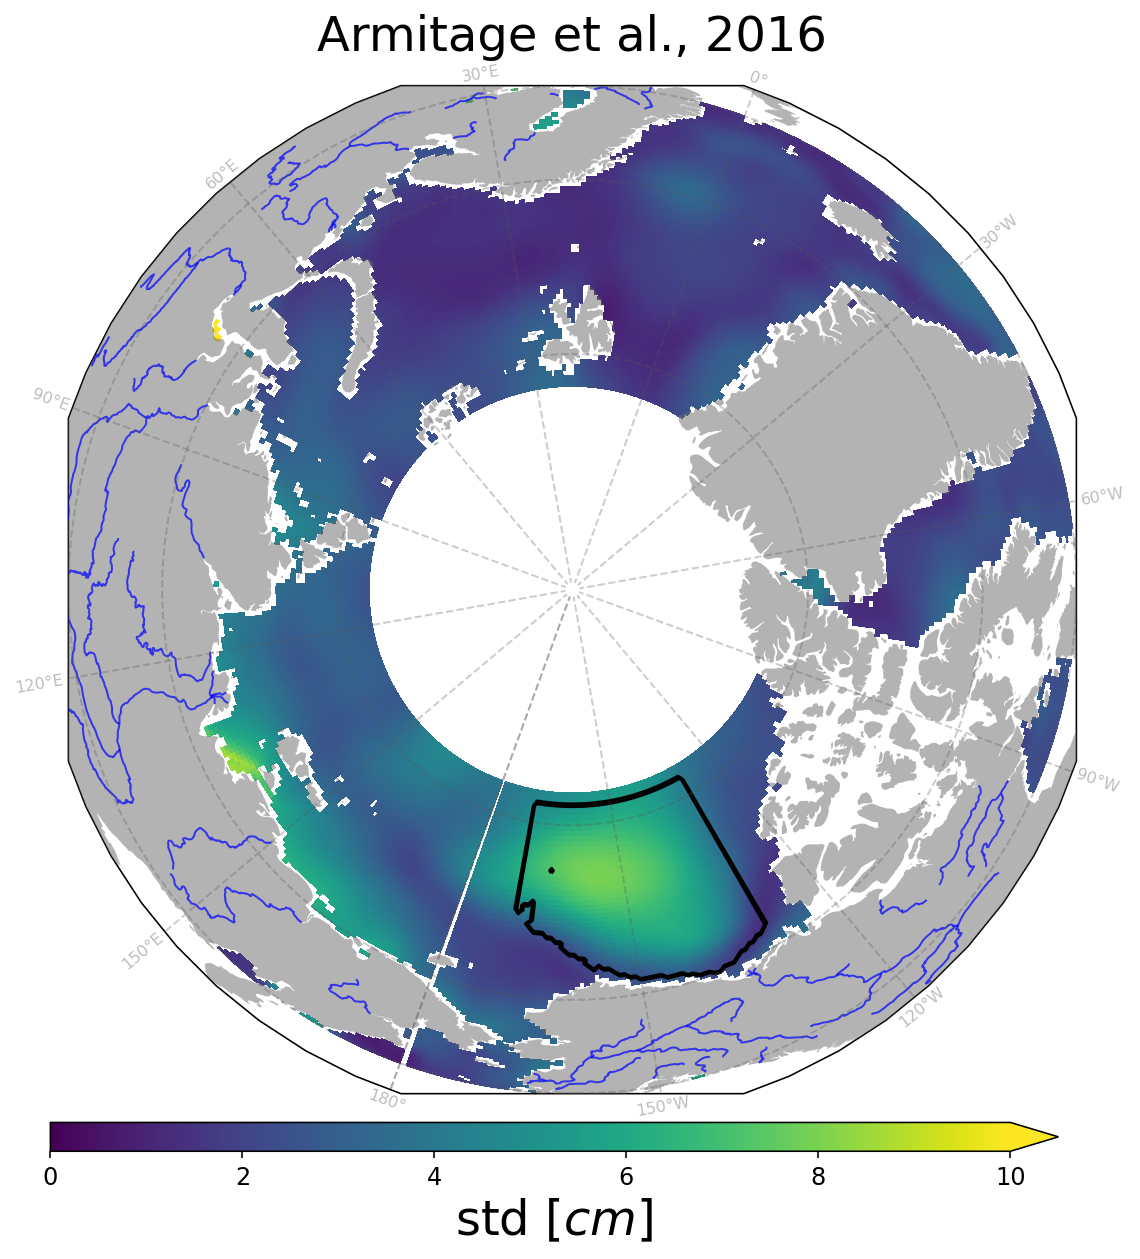

In [7]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (armi_std).squeeze()
axa.contour(longs,lats,armi_BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(longs, lats, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

axa.set_title("Armitage et al., 2016", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## cpom

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


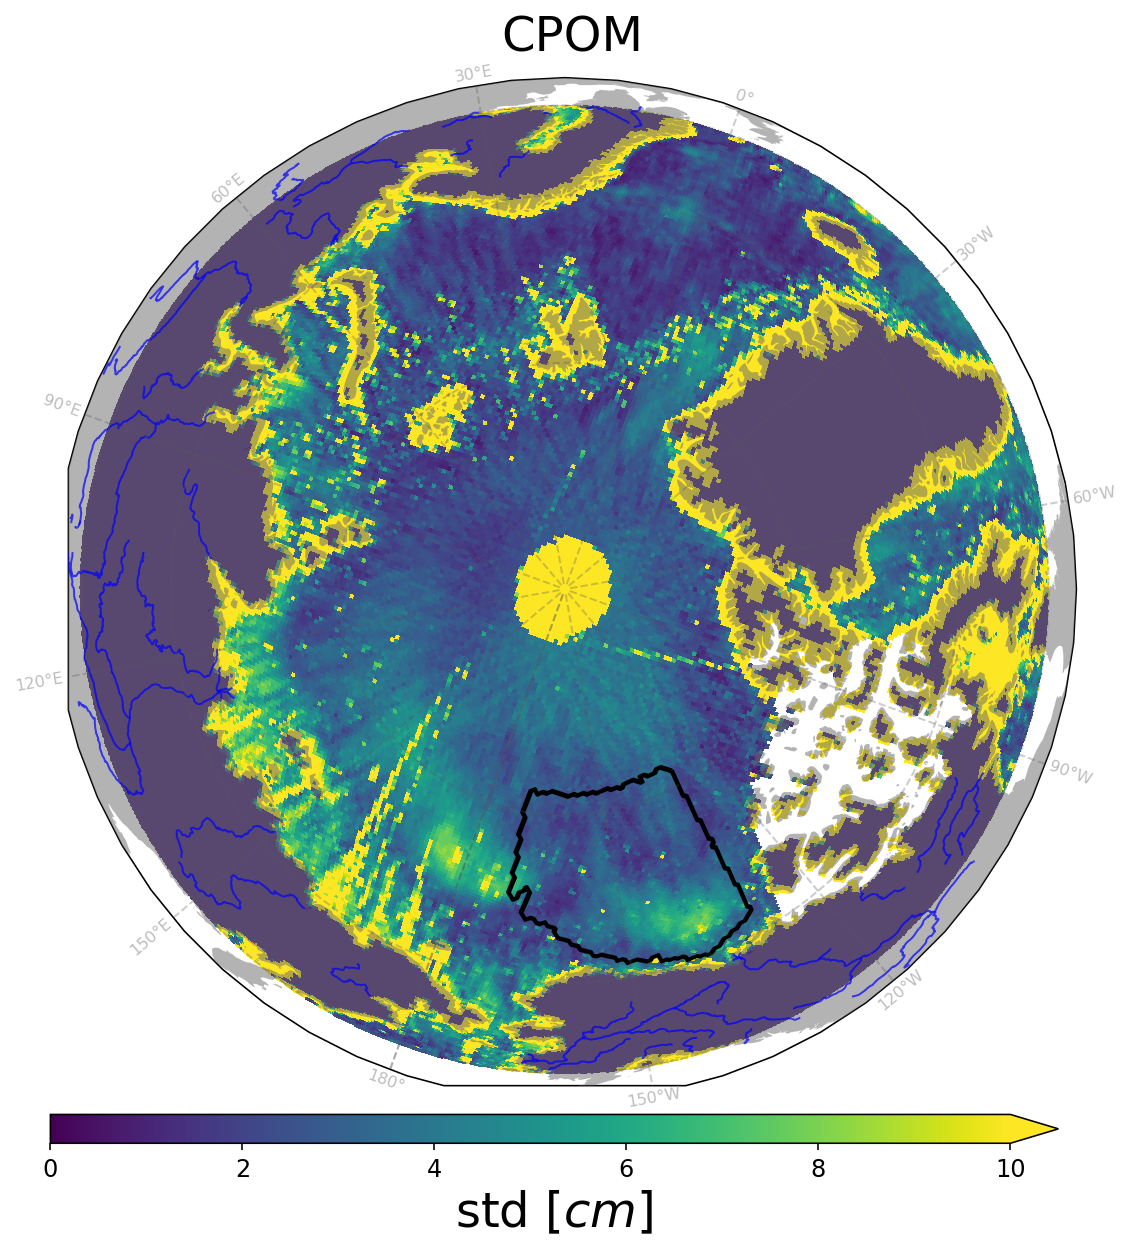

In [7]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (cpom_std).squeeze()
axa.contour(CPOMnav_lon,CPOMnav_lat,CPOM_BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(CPOMnav_lon, CPOMnav_lat, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)


clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style


axa.set_title("CPOM", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## doglioni

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


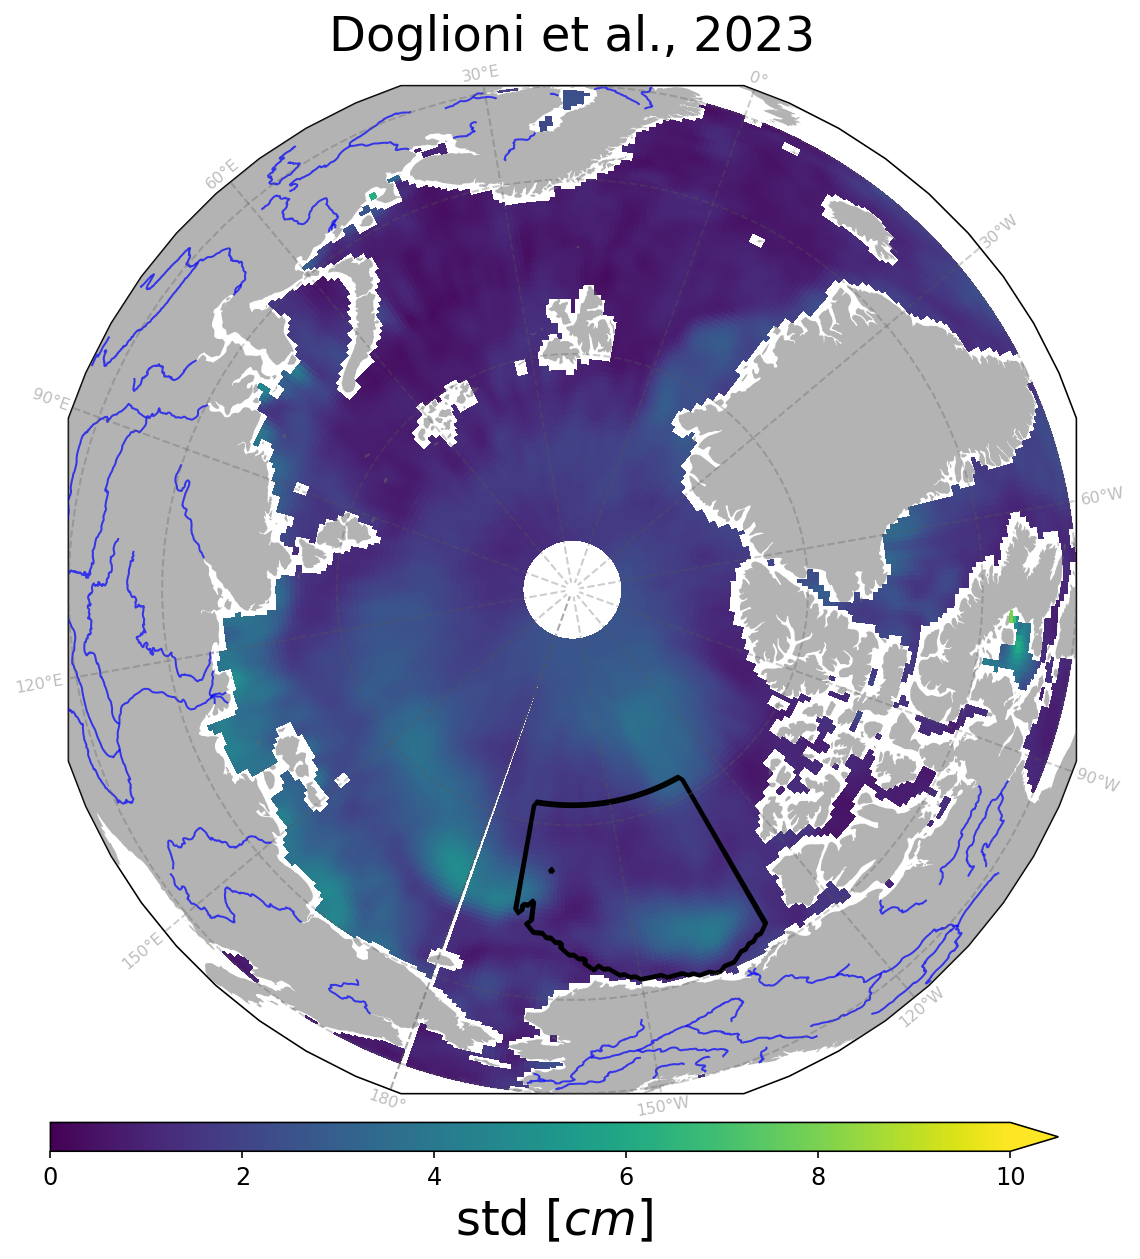

In [19]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (saga_std).squeeze()
axa.contour(SAGAnav_lon,SAGAnav_lat,saga_BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(SAGAnav_lon, SAGAnav_lat, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style


axa.set_title("Doglioni et al., 2023", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## prandi

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


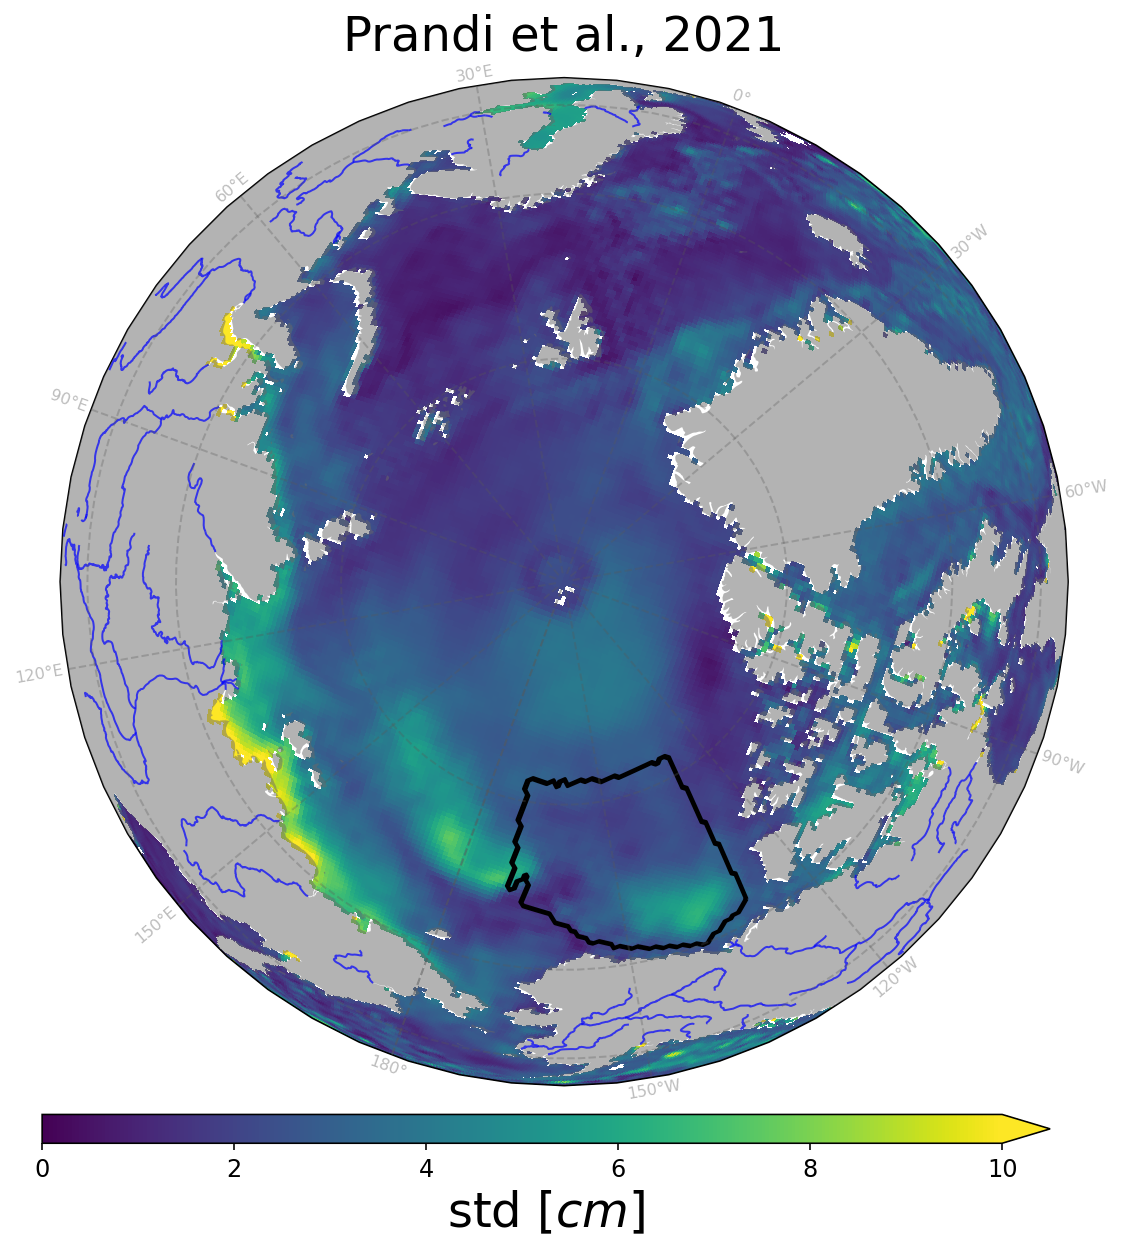

In [30]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (prandi_std).squeeze()
axa.contour(prandi_std.nav_lon,prandi_std.nav_lat,prandi_BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(prandi_std.nav_lon, prandi_std.nav_lat, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style


axa.set_title("Prandi et al., 2021", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## DTU

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


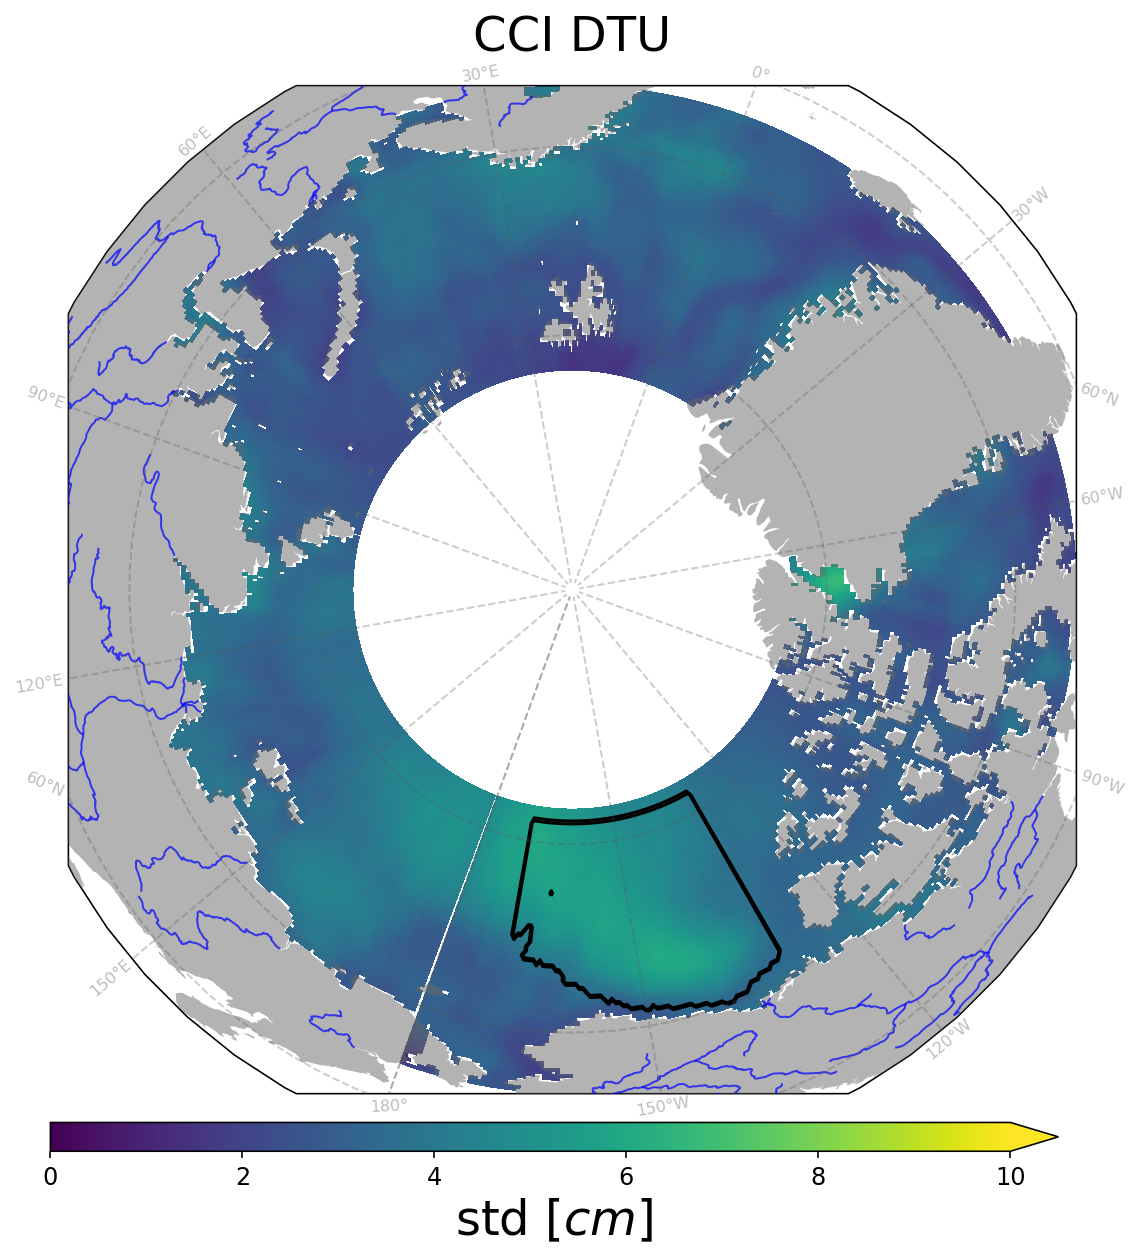

In [129]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (dtu_std).squeeze()
axa.contour(longs,lats,BGRmaskDTU,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(longs.transpose(), lats.transpose(), data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style


axa.set_title("CCI DTU", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

## EXP1

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


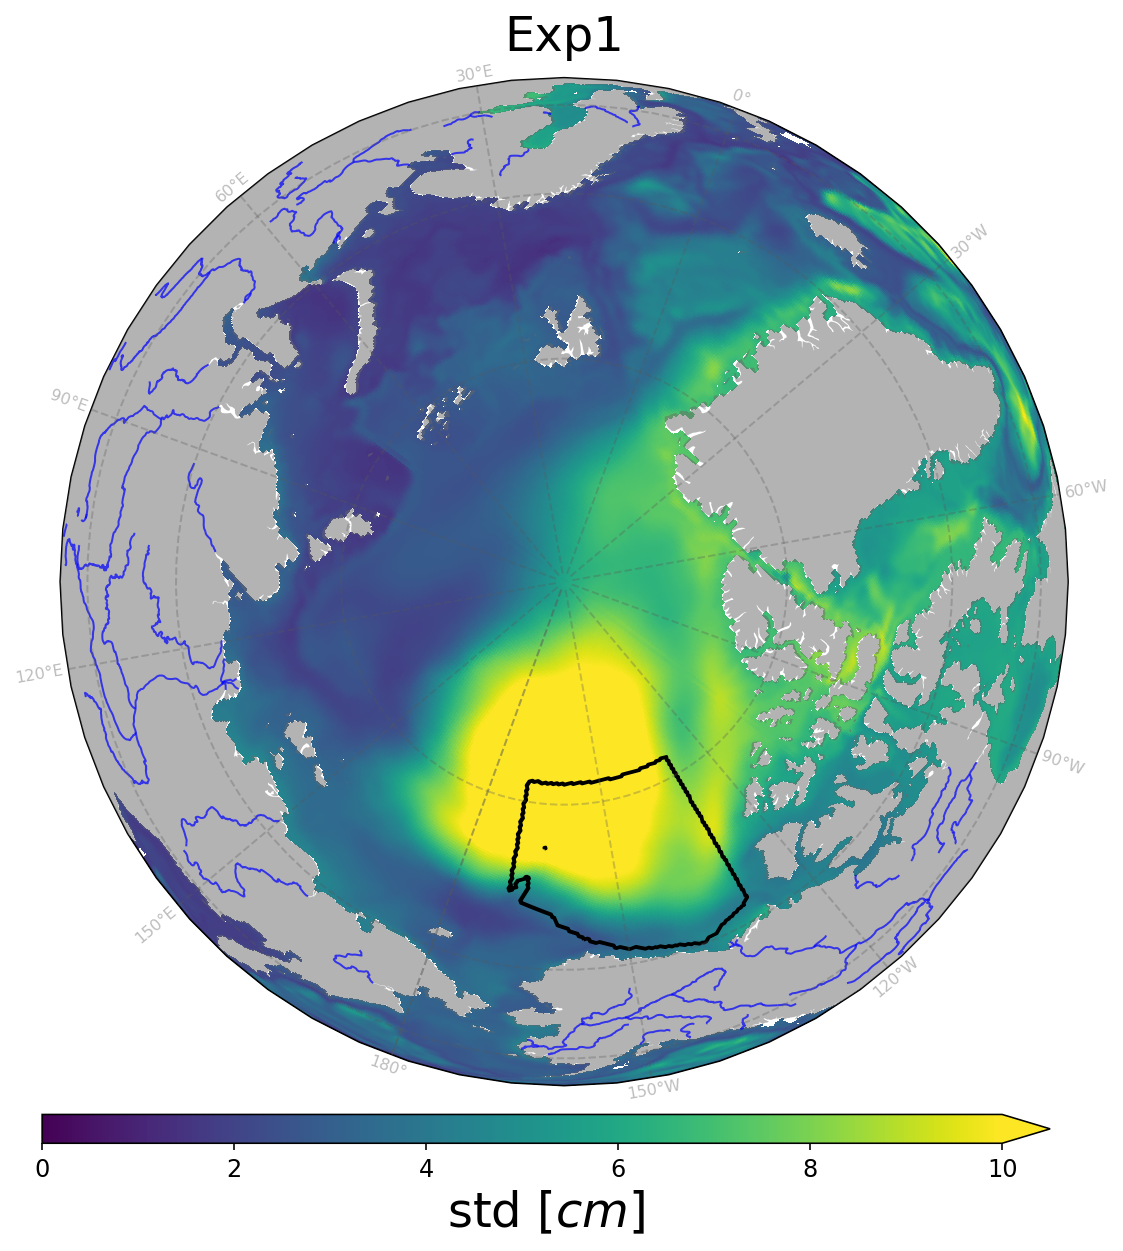

In [51]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)
nav_lon = mesh_hgr.nav_lon
nav_lat = mesh_hgr.nav_lat
BGRmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()


trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
# data2plot = (exp1_std).squeeze()
# data2plot = (exp1_std).where(tmask!=0,0).squeeze()
data2plot = (exp1_std).where(tmask!=0,np.nan).squeeze()

axa.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',transform=trdata, vmax=10, vmin=0) #,norm=norm_SLA)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=.5,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style


axa.set_title("Exp1", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='max', cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'std [$cm$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)